## 1. Imports and Setup
We import necessary libraries and set up custom plot configurations for consistency.

In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye
import From_data_to_binary

# Custom plotting settings
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})


## 2. Data Generation and Preparation
This section defines functions for generating random data points and constructing datasets with anomalies.

In [2]:
# Functions for generating random points and data with anomalies
def generate_random_points(num_points, num_dimensions, radius, shift_factors):
    """Generates random points in 3D with specified characteristic scale."""
    theta, phi = np.random.uniform(0, 2 * np.pi, (2, num_points))
    x = (radius + radius / 6 * np.cos(phi)) * np.cos(theta) + shift_factors[0]
    y = (radius + radius / 6 * np.cos(phi)) * np.sin(theta) + shift_factors[1]
    z = (radius / 6) * np.sin(phi)
    if num_dimensions > 3:
        noise = np.random.normal(0, radius / 2, (num_points, num_dimensions - 3))
        points = np.column_stack((x, y, z, noise))
    else:
        points = np.column_stack((x, y))
    return points

def setup_gaussian_components(num_dimensions=10, background_size=10000, anomaly_size_1=200, anomaly_size_2=200):
    """Sets up Gaussian components for data generation."""
    np.random.seed(77)
    cluster_sizes = [background_size, anomaly_size_1, anomaly_size_2]
    center_shifts = [np.zeros(num_dimensions), 
                     np.array([-0.5, 0] + [0] * (num_dimensions - 3)), 
                     np.array([0.5, 0] + [0] * (num_dimensions - 3))]
    noise_level = 0.01 + np.random.rand() * 0.02
    return num_dimensions, cluster_sizes, center_shifts, noise_level

def generate_data_with_torus_anomalies(num_dimensions, cluster_sizes, anomaly_radius, shift_factors):
    """Generates data with a torus anomaly based on input dimensions and shift factors."""
    np.random.seed(77)
    data_clusters = [np.random.multivariate_normal(np.zeros(num_dimensions), np.eye(num_dimensions), cluster_sizes[0])]
    data_clusters += [generate_random_points(cluster_sizes[i], num_dimensions, anomaly_radius, shift_factors[i-1]) 
                      for i in range(1, 3)]
    return np.vstack(data_clusters)

# Parameters for data generation
sigma_a = 0.3         # Characteristic scale for anomalies
background_size = 10000      # Number of background points
anomaly_size_1 = 200         # Number of points in the first anomaly
anomaly_size_2 = 200         # Number of points in the second anomaly

# Generate data
num_dimensions, cluster_sizes, center_shifts, noise_level = setup_gaussian_components(
    num_dimensions=10, background_size=background_size, anomaly_size_1=anomaly_size_1, anomaly_size_2=anomaly_size_2
)
reference_data = np.random.multivariate_normal([0] * num_dimensions, np.eye(num_dimensions), np.sum(cluster_sizes))
data_no_anomaly = np.random.multivariate_normal([0] * num_dimensions, np.eye(num_dimensions), np.sum(cluster_sizes))
data_with_anomaly = generate_data_with_torus_anomalies(num_dimensions, cluster_sizes, sigma_a, shift_factors=[[0, 1], [-1., -0.5]])


## 3. EagleEye search for anomalies
This section compute the Upsilon for each point of the test sets.

In [3]:
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [4]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 100000            # Number of Bernoulli sequences
K_M = 400                         # Length of each sequence
NUM_CORES = 16
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold

# Generate a Bernoulli matrix with sequences of 0s and 1s
bernoulli_sequences = np.random.binomial(n=1, p=0.5, size=(num_sequences, K_M))

# Compute Upsilon values and optimal k-star values for Bernoulli sequences
p_value_data, upsilon_values_bernoulli, optimal_kstar_bernoulli = compute_upsilon_values(bernoulli_sequences, neighbor_range=NEIGHBOR_RANGE, num_cores=NUM_CORES)

# Calculate the critical Upsilon threshold at the specified quantile
critical_upsilon_threshold = np.quantile(upsilon_values_bernoulli, critical_quantile)


Processing partition 1/17 completed.
Processing partition 2/17 completed.
Processing partition 3/17 completed.
Processing partition 4/17 completed.
Processing partition 5/17 completed.
Processing partition 6/17 completed.
Processing partition 7/17 completed.
Processing partition 8/17 completed.
Processing partition 9/17 completed.
Processing partition 10/17 completed.
Processing partition 11/17 completed.
Processing partition 12/17 completed.
Processing partition 13/17 completed.
Processing partition 14/17 completed.
Processing partition 15/17 completed.
Processing partition 16/17 completed.
Processing partition 17/17 completed.


In [5]:
# Generate and process binary sequences with anomalies
binary_sequences_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_with_anomaly, reference_data, num_neighbors=K_M, num_cores=NUM_CORES
)
anomaly_pval_info, upsilon_values_anomaly, kstar_values_anomaly = compute_upsilon_values(
    binary_sequences_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

# Define indices of interest for anomaly data
positive_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, upsilon_thresh=100, kstar_thresh=250)
negative_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, upsilon_thresh=8, kstar_thresh=90, condition='<')

# Collect Upsilon values for selected indices in anomaly data
upsilon_values_anomaly_selected = extract_upsilon_values(anomaly_pval_info, [positive_indices[7], 359, negative_indices[17]], NEIGHBOR_RANGE)

# Generate and process binary sequences without anomalies
binary_sequences_no_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_no_anomaly, reference_data, num_neighbors=K_M, num_cores=NUM_CORES
)
no_anomaly_pval_info, upsilon_values_no_anomaly, kstar_values_no_anomaly = compute_upsilon_values(
    binary_sequences_no_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

# Define indices of interest for no-anomaly data
no_anomaly_indices_a = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=10, kstar_thresh=50, condition='>')
no_anomaly_indices_b = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=6, kstar_thresh=180, condition='<')
no_anomaly_indices_c = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=2, kstar_thresh=200, condition='<')

# Collect Upsilon values for selected indices in no-anomaly data
upsilon_values_no_anomaly_selected = extract_upsilon_values(no_anomaly_pval_info, [no_anomaly_indices_a[1], no_anomaly_indices_b[17], no_anomaly_indices_c[10]], NEIGHBOR_RANGE)


Processing partition 1/104
Processing partition 2/104
Processing partition 3/104
Processing partition 4/104
Processing partition 5/104
Processing partition 7/104
Processing partition 6/104
Processing partition 8/104
Processing partition 9/104
Processing partition 10/104
Processing partition 11/104
Processing partition 12/104
Processing partition 13/104
Processing partition 14/104
Processing partition 15/104
Processing partition 16/104
Processing partition 17/104
Processing partition 18/104
Processing partition 19/104
Processing partition 22/104
Processing partition 20/104
Processing partition 21/104
Processing partition 23/104
Processing partition 25/104
Processing partition 24/104
Processing partition 26/104
Processing partition 28/104
Processing partition 27/104
Processing partition 29/104
Processing partition 31/104
Processing partition 30/104
Processing partition 32/104
Processing partition 33/104
Processing partition 34/104
Processing partition 36/104
Processing partition 35/104
P

In [6]:
index_positives_T = np.where((upsilon_values_anomaly > 100) & (np.array(kstar_values_anomaly) < 250))[0][7]
index_positives_F = 359 
index_negatives_q = np.where((upsilon_values_anomaly < 8) & (np.array(kstar_values_anomaly) > 90))[0][ 17]

NLPval_all3 = []
NLPval_all4 = []
NLPval_all5 = []
for j in range(4, 400):
    NLPval_all3.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_T, 0]))
    NLPval_all4.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_F, 0]))
    NLPval_all5.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_negatives_q, 0]))
    
upsilon_values_anomaly_selected = [ np.array(NLPval_all3), np.array(NLPval_all4), np.array(NLPval_all5) ]


# index_negatives_ = np.where(NLPval_no_anomaly < 15)[0][[1631, 37, 77]]

index_negatives_a = np.where((upsilon_values_no_anomaly > 9) & (upsilon_values_no_anomaly < 11) & (np.array(kstar_values_no_anomaly) > 50))[0][ 1]
index_negatives_b = np.where((upsilon_values_no_anomaly > 5) & (upsilon_values_no_anomaly < 7) & (np.array(kstar_values_no_anomaly) < 210) & (np.array(kstar_values_no_anomaly) > 170) )[0][ 17]
index_negatives_c = np.where((upsilon_values_no_anomaly > 1) & (upsilon_values_no_anomaly < 3) & (np.array(kstar_values_no_anomaly) > 200))[0][ 10]

NLPval_all0 = []
NLPval_all1 = []
NLPval_all2 = []
for j in range(4, 400):
    NLPval_all1.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_a, 0]))
    NLPval_all2.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_b, 0]))
    NLPval_all0.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_c, 0]))

upsilon_values_no_anomaly_selected = [ np.array(NLPval_all0), np.array(NLPval_all1), np.array(NLPval_all2) ]

## 4. Plotting and Visualization
This section defines functions and visualizations for analyzing and displaying $\Upsilon$ sequences.

In [7]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')



Computation of distances started
Computation of the distances up to 100 NNs started
0.04 seconds for computing distances
ID estimation finished: selecting ID of [9.21]
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.001 sec
('Number of clusters before multimodality test=', 18)
Identification of the saddle points:  0.003 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0001201629638671875 sec
Clustering finished, 2 clusters found
total time is, 0.004468202590942383


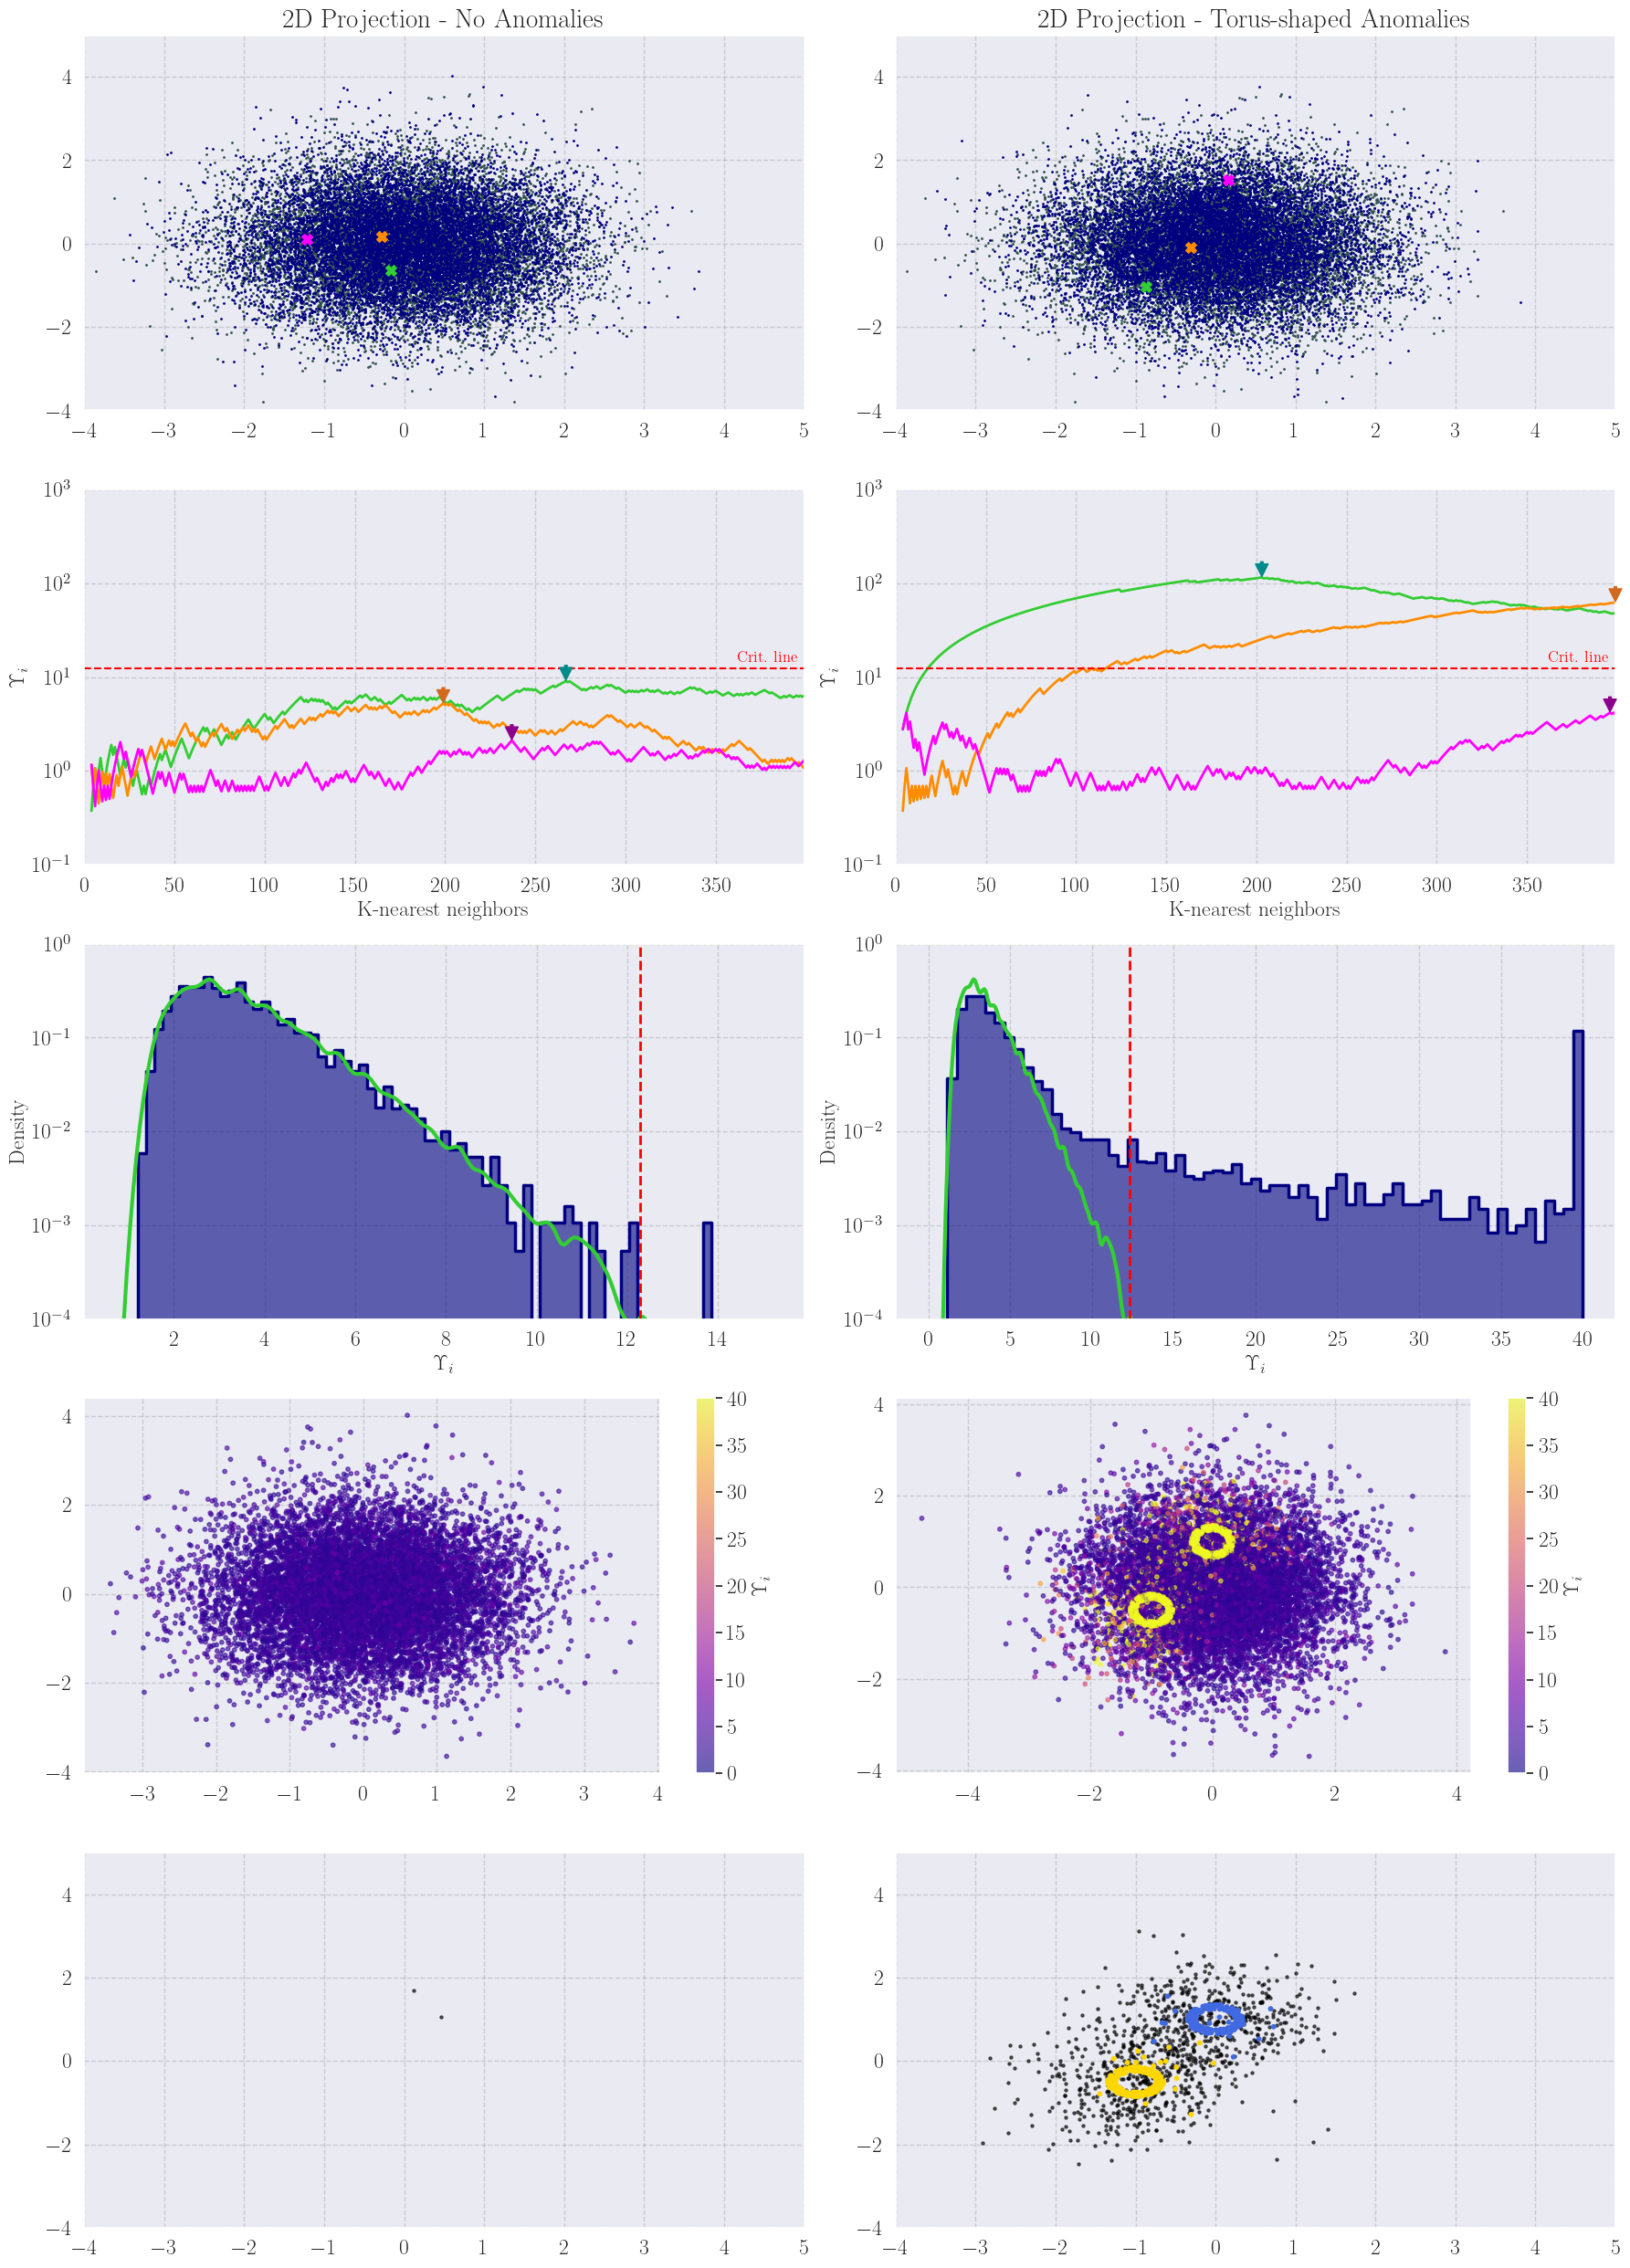

In [8]:
# Figure 1 article

custom_rgb = (234 / 255, 234 / 255, 242 / 255)
axislim = [-4, 5]
crit_val = critical_upsilon_threshold  # Example critical value


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


# Set up the 5x2 grid for subplots
fig, axs = plt.subplots(5, 2, figsize=(18, 25))

# Scatter plots for no-anomaly and anomaly data in the first row
axs[0, 0].scatter(reference_data[:, 0], reference_data[:, 1], s=1.0, color='darkslategray', label='Reference')
axs[0, 0].scatter(data_no_anomaly[:, 0], data_no_anomaly[:, 1], s=1.0, color='navy', label='Data')
axs[0, 0].set_title('2D Projection - No Anomalies')
axs[0, 0].set_xlim(axislim)
axs[0, 0].set_ylim(axislim)

axs[0, 1].scatter(reference_data[:, 0], reference_data[:, 1], s=1.0, color='darkslategray', label='Reference')
axs[0, 1].scatter(data_with_anomaly[:, 0], data_with_anomaly[:, 1], s=1.0, color='navy', label='Data')
axs[0, 1].set_title('2D Projection - Torus-shaped Anomalies')
axs[0, 1].set_xlim(axislim)
axs[0, 1].set_ylim(axislim)

# Row 2: Upsilon plots for no anomalies and with anomalies
plot_nlpval(axs[1, 0], upsilon_values_no_anomaly_selected[1], upsilon_values_no_anomaly_selected[2], 
            upsilon_values_no_anomaly_selected[0], label1='TN1', label2='TN2', label3='TN3', crit_v=crit_val)
axs[1, 0].set_ylim([1e-1, 1000])

plot_nlpval(axs[1, 1], upsilon_values_anomaly_selected[0], upsilon_values_anomaly_selected[1], 
            upsilon_values_anomaly_selected[2], label1='TP', label2='FP', label3='TN', crit_v=crit_val)
axs[1, 1].set_ylim([1e-1, 1000])

# back to Row1

#%% add the points to the previous row
axs[0, 0].scatter(data_no_anomaly[index_negatives_a, 0], data_no_anomaly[index_negatives_a, 1], s=70.0, marker='X', c='limegreen', alpha=1, label='TN1')
axs[0, 0].scatter(data_no_anomaly[index_negatives_b, 0], data_no_anomaly[index_negatives_b, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='TN2')
axs[0, 0].scatter(data_no_anomaly[index_negatives_c, 0], data_no_anomaly[index_negatives_c, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN3')
# axs[0, 0].legend()
axs[0, 1].scatter(data_with_anomaly[index_positives_T, 0], data_with_anomaly[index_positives_T, 1], s=70.0, marker='X',c='limegreen', alpha=1, label='TP')
axs[0, 1].scatter(data_with_anomaly[index_positives_F, 0], data_with_anomaly[index_positives_F, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='FP')
axs[0, 1].scatter(data_with_anomaly[index_negatives_q, 0], data_with_anomaly[index_negatives_q, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN')
# axs[0, 1].legend()


# Row 3: Histograms of Upsilon distributions
sns.histplot(upsilon_values_no_anomaly, bins=70, kde=False, stat='density', label='No Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 0])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 0])
axs[2, 0].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel(r'$\Upsilon_i$')
axs[2, 0].set_ylim([1e-4, 1e0])

sns.histplot(np.clip(upsilon_values_anomaly, a_min=None, a_max=40), bins=np.linspace(0, 40, 70), kde=False, stat='density', label='With Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 1])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 1])
axs[2, 1].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel(r'$\Upsilon_i$')
axs[2, 1].set_ylim([1e-4, 1e0])

# Row 4: Color-coded scatter plots by Upsilon
sc1 = axs[3, 0].scatter(data_no_anomaly[:, 0], data_no_anomaly[:, 1], s=10.0, c=upsilon_values_no_anomaly[:], cmap='plasma', alpha=0.6, vmin=0, vmax=40)
plt.colorbar(sc1, ax=axs[3, 0], label=r'$\Upsilon_i$')
sc2 = axs[3, 1].scatter(data_with_anomaly[:, 0], data_with_anomaly[:, 1], s=10.0, c=upsilon_values_anomaly[:], cmap='plasma', alpha=0.6, vmin=0, vmax=40)
plt.colorbar(sc2, ax=axs[3, 1], label=r'$\Upsilon_i$')


# Row5: Clustering

from matplotlib.colors import ListedColormap, BoundaryNorm
colorsss = ['royalblue', 'gold' , 'green', 'purple',  'cyan']


from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


X = data_with_anomaly[upsilon_values_anomaly>crit_val,:]

data = Data(X, verbose=True)
data.compute_distances(maxk=100)
data.compute_id_2NN()
data.compute_density_kstarNN()
data.compute_clustering_ADP(Z=2.65, halo=True)

Nclus_m = len(data.cluster_centers)
cmap = plt.get_cmap("cool", Nclus_m)
mix_clustered_ = np.squeeze(X[data.cluster_assignment[:] != -1,:])
mix_clustered_halo = np.squeeze(X[data.cluster_assignment[:] == -1,:])

axs[4, 1].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)

# Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
unique_clusters = sorted(set(data.cluster_assignment[data.cluster_assignment > -1]))

# Create a colormap using only as many colors as the number of unique clusters
cmap = ListedColormap(colorsss[:len(unique_clusters)])

# Create a BoundaryNorm that matches the number of clusters
norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)

sc = axs[4, 1].scatter(
mix_clustered_[:, 0],               # x-coordinates
mix_clustered_[:, 1],               # y-coordinates
s=10.0,                             # marker size
c=data.cluster_assignment[data.cluster_assignment > -1],  # Use cluster assignments directly
cmap=cmap,                           # Use the ListedColormap
norm=norm,                           # Normalize the colors
alpha=1   )                           # Transparency 
 
axs[4, 1].set_xlim(axislim)
axs[4, 1].set_ylim(axislim)


X = data_no_anomaly[upsilon_values_no_anomaly>crit_val,:]
if X.shape[0]>20:
    data = Data(X, verbose=True)
    data.compute_distances(maxk=20)
    data.compute_id_2NN()
    data.compute_density_kstarNN()
    data.compute_clustering_ADP(Z=2.65, halo=True)
    
    Nclus_m = len(data.cluster_centers)
    cmap = plt.get_cmap("cool", Nclus_m)
    mix_clustered_ = np.squeeze(X[data.cluster_assignment[:] != -1,:])
    mix_clustered_halo = np.squeeze(X[data.cluster_assignment[:] == -1,:])
    
    axs[4, 0].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)
    # Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
    unique_clusters = sorted(set(data.cluster_assignment[data.cluster_assignment > -1]))
    
    # Create a colormap using only as many colors as the number of unique clusters
    cmap = ListedColormap(colorsss[:len(unique_clusters)])
    
    # Create a BoundaryNorm that matches the number of clusters
    norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)
    sc = axs[4, 1].scatter(
    mix_clustered_[:, 0],               # x-coordinates
    mix_clustered_[:, 1],               # y-coordinates
    s=10.0,                             # marker size
    c=data.cluster_assignment[data.cluster_assignment > -1],  # Use cluster assignments directly
    cmap=cmap,                           # Use the ListedColormap
    norm=norm,                           # Normalize the colors
    alpha=1   )    
    axs[4, 0].set_xlim(axislim)
    axs[4, 0].set_ylim(axislim)

else:
    axs[4, 0].scatter(X[:,0],X[:,1], s=5.0, c='black', alpha=0.6)
    axs[4, 0].set_xlim(axislim)
    axs[4, 0].set_ylim(axislim)

plt.tight_layout()
plt.show()

# Adding labels to each subplot
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
for ax, label in zip(axs[:,:].flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='left')
    


### 4.1 Plotting and Visualization: Supplement, Figure 4 


Text(0.5, 1.0, 'F1_B:hist of 2nd component')

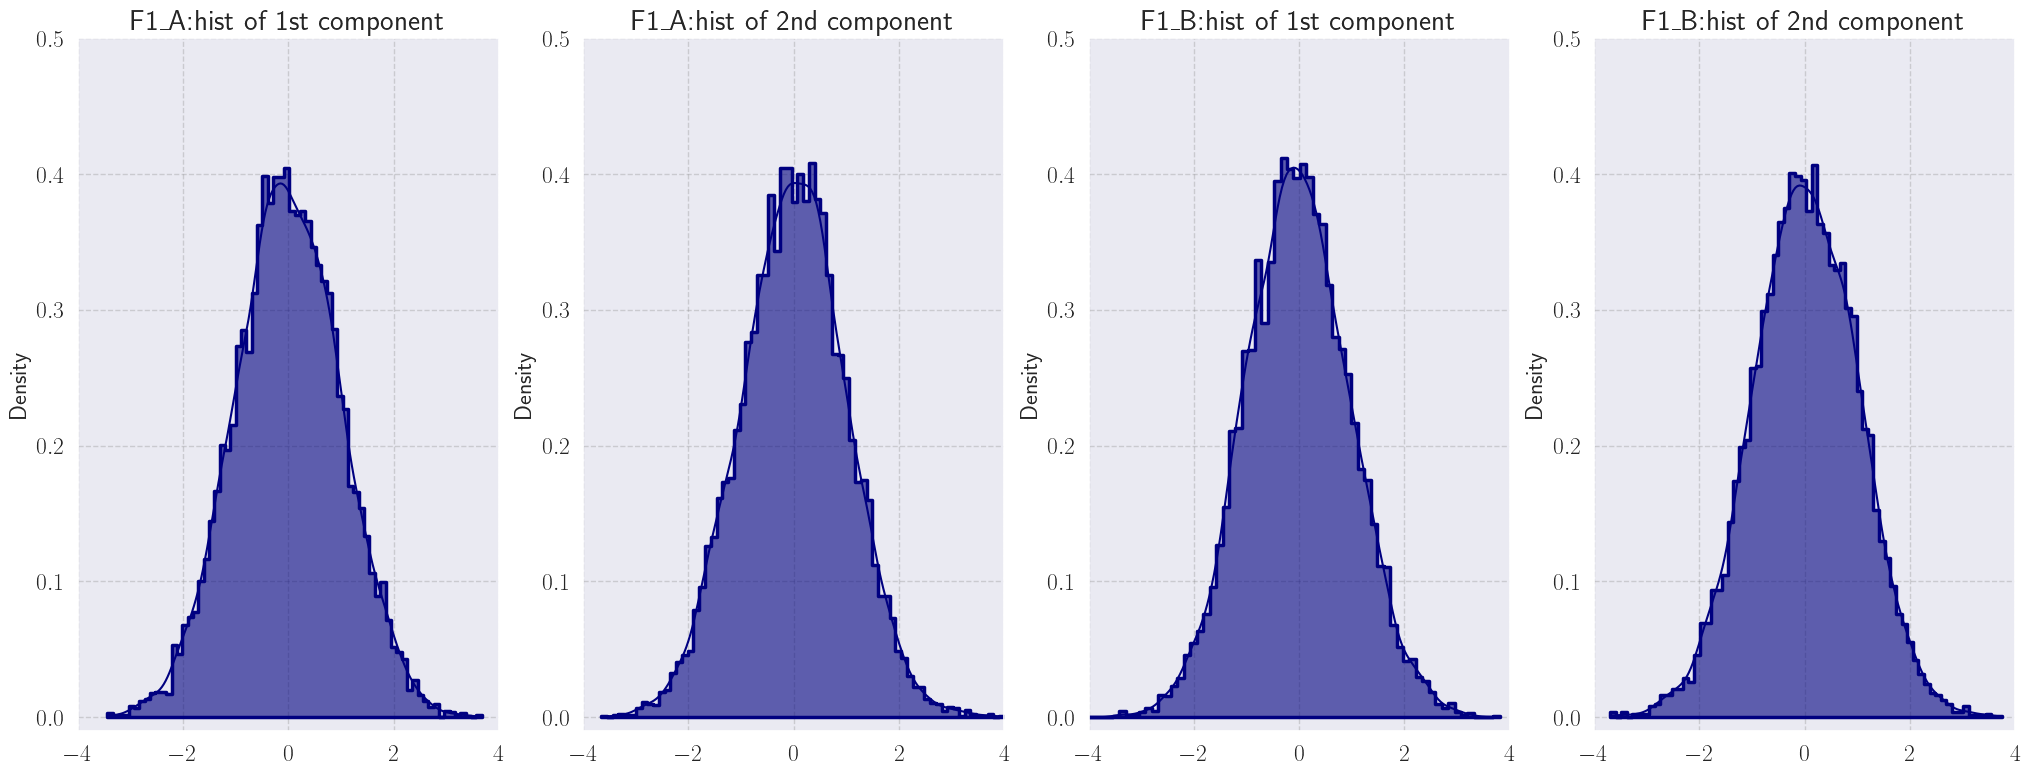

In [9]:
# Set up custom styles for the plots
sns.set(style="darkgrid")

plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})
custom_rgb = (234/255, 234/255, 242/255) # to get the same colour for text
# Create 5x3 grid for the plots
fig, axs = plt.subplots(1, 4, figsize=(25, 9))

sns.histplot(data_no_anomaly[:,0], bins=70, kde=True, stat='density', label='Reference/New signal (no Anomaly)', color='navy', element='step', linewidth=2.5, alpha=0.6,ax=axs[0])
sns.histplot(data_no_anomaly[:,1], bins=70, kde=True, stat='density', label='Reference/New signal (no Anomaly)', color='navy', element='step', linewidth=2.5, alpha=0.6,ax=axs[1])

sns.histplot(data_with_anomaly[:,0], bins=70, kde=True, stat='density', label='Reference/New signal ( Anomaly)', color='navy', element='step', linewidth=2.5, alpha=0.6,ax=axs[2])
sns.histplot(data_with_anomaly[:,1], bins=70, kde=True, stat='density', label='Reference/New signal ( Anomaly)', color='navy', element='step', linewidth=2.5, alpha=0.6,ax=axs[3])

axs[0].set_xlim([-4,4])
axs[1].set_xlim([-4,4])
axs[2].set_xlim([-4,4])
axs[3].set_xlim([-4,4])

axs[0].set_ylim([-0.01,.5])
axs[1].set_ylim([-0.01,.5])
axs[2].set_ylim([-0.01,.5])
axs[3].set_ylim([-0.01,.5])

axs[0].set_title('F1_A:hist of 1st component')
axs[1].set_title('F1_A:hist of 2nd component')
axs[2].set_title('F1_B:hist of 1st component')
axs[3].set_title('F1_B:hist of 2nd component')



### 4.2 Plotting and Visualization: Supplement, Figure 7 


In [10]:
#%% Generate the data and compute the statistic


# Parameters for data generation
sigma_a = 0.3                # Characteristic scale for anomalies
background_size = 100000      # Number of background points
anomaly_size_1 = 100         # Number of points in the first anomaly
anomaly_size_2 = 70         # Number of points in the second anomaly
K_M = 100                    # max neighbourhood size
dim = 10

num_sequences = 100000            # Number of Bernoulli sequences
NUM_CORES = 10
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold
partition_size = 500

# Generate data
num_dimensions, cluster_sizes, center_shifts, noise_level = setup_gaussian_components(
    num_dimensions=dim, background_size=background_size, anomaly_size_1=anomaly_size_1, anomaly_size_2=anomaly_size_2
)

reference_data = np.random.multivariate_normal([0] * num_dimensions, np.eye(num_dimensions), np.sum(cluster_sizes))

data_with_anomaly = generate_data_with_torus_anomalies(num_dimensions, cluster_sizes, sigma_a, shift_factors=[[0, 1], [-1., -0.5]])
# Generate and process binary sequences with anomalies
binary_sequences_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_with_anomaly, reference_data, num_neighbors=K_M, num_cores=NUM_CORES, partition_size = partition_size
)
anomaly_pval_info, upsilon_values_anomaly, kstar_values_anomaly = compute_upsilon_values(
    binary_sequences_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

data_no_anomaly = np.random.multivariate_normal([0] * num_dimensions, np.eye(num_dimensions), np.sum(cluster_sizes))
# Generate and process binary sequences without anomalies
binary_sequences_no_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_no_anomaly, reference_data, num_neighbors=K_M, num_cores=NUM_CORES, partition_size = partition_size
)
no_anomaly_pval_info, upsilon_values_no_anomaly, kstar_values_no_anomaly = compute_upsilon_values(
    binary_sequences_no_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

# Generate a Bernoulli matrix with sequences of 0s and 1s
bernoulli_sequences = np.random.binomial(n=1, p=0.5, size=(num_sequences, K_M))

# Compute Upsilon values and optimal k-star values for Bernoulli sequences
p_value_data, upsilon_values_bernoulli, optimal_kstar_bernoulli = compute_upsilon_values(bernoulli_sequences, neighbor_range=NEIGHBOR_RANGE, num_cores=NUM_CORES)

# Calculate the critical Upsilon threshold at the specified quantile
critical_upsilon_threshold = np.quantile(upsilon_values_bernoulli, critical_quantile)

crit_val = critical_upsilon_threshold



from scipy.stats import ks_2samp, anderson_ksamp, cramervonmises_2samp

# Perform the statistical tests
cvm_global = cramervonmises_2samp(upsilon_values_anomaly, upsilon_values_no_anomaly)
ad_global = anderson_ksamp([upsilon_values_anomaly, upsilon_values_no_anomaly])
ks_global = ks_2samp(upsilon_values_anomaly, upsilon_values_no_anomaly)

# Print the results
print(f"Cramér–von Mises statistic: {cvm_global.statistic}, p-value: {cvm_global.pvalue}")
print(f"Anderson-Darling statistic: {ad_global.statistic}, p-value: {ad_global.pvalue}")
print(f"Kolmogorov-Smirnov statistic: {ks_global.statistic}, p-value: {ks_global.pvalue}")

Processing partition 5/201
Processing partition 4/201
Processing partition 6/201
Processing partition 7/201
Processing partition 10/201
Processing partition 8/201
Processing partition 2/201
Processing partition 3/201
Processing partition 9/201
Processing partition 1/201
Processing partition 14/201
Processing partition 11/201
Processing partition 16/201
Processing partition 15/201
Processing partition 12/201
Processing partition 17/201
Processing partition 13/201
Processing partition 19/201
Processing partition 20/201
Processing partition 18/201
Processing partition 21/201
Processing partition 23/201
Processing partition 25/201
Processing partition 22/201
Processing partition 26/201
Processing partition 24/201
Processing partition 29/201
Processing partition 27/201
Processing partition 28/201
Processing partition 30/201
Processing partition 31/201
Processing partition 33/201
Processing partition 34/201
Processing partition 35/201
Processing partition 37/201
Processing partition 36/201
P

Processing partition 75/201
Processing partition 77/201
Processing partition 78/201
Processing partition 76/201
Processing partition 80/201
Processing partition 79/201
Processing partition 81/201
Processing partition 83/201
Processing partition 82/201
Processing partition 84/201
Processing partition 86/201
Processing partition 85/201
Processing partition 87/201
Processing partition 89/201
Processing partition 88/201
Processing partition 90/201
Processing partition 91/201
Processing partition 93/201
Processing partition 92/201
Processing partition 94/201
Processing partition 95/201
Processing partition 96/201
Processing partition 98/201
Processing partition 97/201
Processing partition 99/201
Processing partition 100/201
Processing partition 101/201
Processing partition 103/201
Processing partition 104/201
Processing partition 105/201
Processing partition 102/201
Processing partition 106/201
Processing partition 109/201
Processing partition 107/201
Processing partition 110/201
Processing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


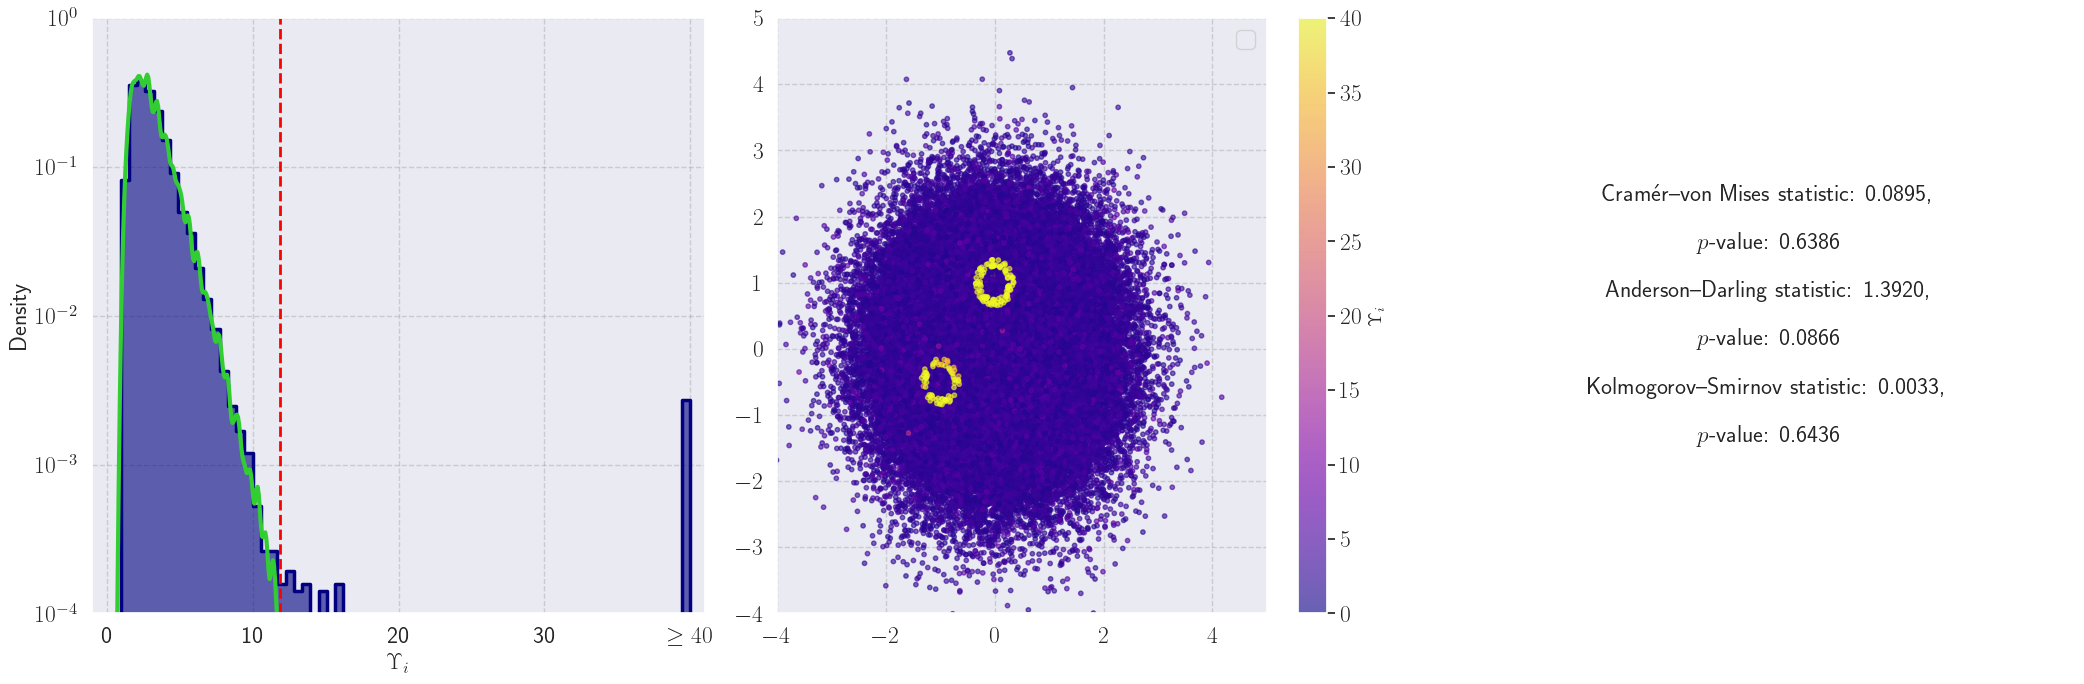

In [12]:

# Create a 1x3 grid for the plots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

#%%

axislim = [-4, 5]
# Step 1: Clip values at 40
NLPval_anomaly_clipped = np.clip(upsilon_values_anomaly, a_min=None, a_max=40)

# Step 2: Define custom bins
bins = np.linspace(min(NLPval_anomaly_clipped), 40, 70)  # 70 bins up to 40

# Step 3: Plot the histogram in the first panel
sns.histplot(
    NLPval_anomaly_clipped,
    bins=bins,
    kde=False,
    stat='density',
    label='Reference/New signal (With Anomaly)',
    color='navy',
    element='step',
    linewidth=2.5,
    alpha=0.6,
    ax=axs[0]
)

# Add the critical value line
axs[0].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Crit. value')
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[0])

axs[0].set_yscale('log')  # Set y-axis to log scale
axs[0].set_xlabel(r'$\Upsilon_{i}$')
axs[0].set_ylim([1e-4, 1e0])
axs[0].set_xlim([-1, 41])

# Get the current xticks and labels
xticks = axs[0].get_xticks()
xtick_labels = [f"{int(tick)}" for tick in xticks]  # Convert the ticks to integers for the labels

# Modify the last label to be '≥ 40'
if len(xtick_labels) > 0:
    xtick_labels[-2] = r"$\geq 40$"  # Change the second-to-last label to "≥ 40"

# Set the modified labels
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xtick_labels)
axs[0].set_xlim([-1, 41])

#%%

# Plot NLPval for anomalies in the second panel
sc1 = axs[1].scatter(
    data_with_anomaly[:, 0],
    data_with_anomaly[:, 1],
    s=10.0,
    c=upsilon_values_anomaly[:],
    cmap='plasma',
    alpha=0.6,
    vmin=0,
    vmax=40
)
axs[1].legend()
cbar2 = plt.colorbar(sc1, ax=axs[1])
cbar2.set_label(r'$\Upsilon_{i}$', fontsize=14)
axs[1].set_xlim(axislim)
axs[1].set_ylim(axislim)

#%%

# Third panel: Display statistical test results
# Remove axes for the third panel
axs[2].axis('off')

# Prepare the text with proper formatting
stat_text = (
    rf"Cramér--von Mises statistic: {cvm_global.statistic:.4f}," + '\n\n'
    rf"                    $p$-value: {cvm_global.pvalue:.4f}" + '\n\n'
    rf"Anderson--Darling statistic: {ad_global.statistic:.4f}," + '\n\n'
    rf"                    $p$-value: {ad_global.pvalue:.4f}" + '\n\n'
    rf"Kolmogorov--Smirnov statistic: {ks_global.statistic:.4f}," + '\n\n'
    rf"                    $p$-value: {ks_global.pvalue:.4f}"
)
# Add the text to the third panel
axs[2].text(
    0.5, 0.5, stat_text,
    fontsize=17,
    ha='center',
    va='center',
    transform=axs[2].transAxes
)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

# Adding labels to each subplot
labels = ['A', 'B', 'C']
for ax, label in zip(axs[:].flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='left')
    
    
    